## Periodic Array

Calculate output field for a plane wave of wave number k and
amplitude A0 passing through  
1) aperture plate: rectangular grid of spots of radius a, dx,dy center to center; spots can be transmissive or reflective  
2) lens f1  
3) circular aperture radius b  
4) lens f2  

In [22]:
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift
from scipy.integrate import quad, dblquad
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from time import time, perf_counter_ns
import random as rand

## make the display wide
from IPython.core.display import HTML, display
display(HTML("<style>.container{width:100% !important;}</style>"))

TODO: 
1) make field input aperture periodic, 1D  
2) plot axial field from lens f2 onward using eq i derived

In [134]:
## functions

def from_quadrant3(qd3, field=None):
    """
    construct field with rectangular symmetry given only
    quadrant 3 (i.e., field is mirrored across x axis and
    across y axis)
    
    'qd3' 2D numpy array
    Return 'field' 2D numpy array
    """
    
    xpts, ypts = qd3.shape
    xmpt, ympt = int(xpts/2), int(ypts/2)
    
    if field is None:
        field = zeros((2*xpts, 2*ypts), complex)
    
    field[:midpt, :midpt] = qd3
    # qd4
    field[:midpt, midpt:] = flip(qd3, axis=1) 
    # qd1
    field[midpt:, midpt:] = flip(qd3)
    # qd2
    field[midpt:, :midpt] = flip(qd3, axis=0)
    
    return field

def get_meshgrid(w, pts, polar=False):
    """
    'w': grid half width
    'pts': pts along one dimension; i.e. the full grid is pts x pts
    """
    midpt = int(pts/2)
    x = linspace(-w, w, pts)
    y = linspace(-w, w, pts)
    xx, yy = meshgrid(x,y, sparse=True)
    if polar:
        rr = sqrt(xx**2 + yy**2)
        phi = arctan2(yy,xx)
        phi[:midpt, :] += 2*pi
        return x,midpt,rr,phi
    else:
        return x,midpt,xx,yy
    
def get_grid(dx,dy,xnum,ynum):
    xpts = []
    ypts = []
    for i in range(xnum):
        for j in range(ynum):
            xpts.append((1+i)*dy - dy*(1+ynum)/2)
            ypts.append((1+j)*dx - dx*(1+xnum)/2)
    return xpts, ypts

def figax(roi=None, ylabel='y/a', xlabel='x/a'):
    fig,ax = plt.subplots()
    if roi is not None:
        ax.set_xlim(-roi,roi)
        ax.set_ylim(-roi,roi)
    ax.set_aspect('equal')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig, ax

In [5]:
## physics and system params
k = 2*pi/1.064e-6
A0 = 1
# want M = f2/f1 something like ~ .03
f1 = 1
f2 = 0.03
a = 1e-4 # aperture 1 radius = 100 um
b = f1*3.8317/(a*k) # the filter radius. 3.8317 is a00, the first zero of the J0(x).

dx = 3*a # center-to-center spacing between spots
dy = dx

(-0.0006000000000000001, 0.0006000000000000001)

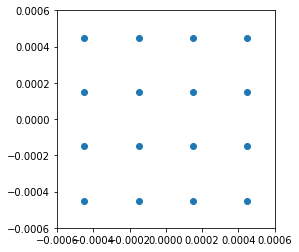

In [5]:
xspots = 4
yspots = 4
xpts, ypts = get_grid(dx,dy,xspots,yspots)

# lines = []
# for i in range(yspots):
#     for j in range(xspots):
#         lines.append([[0, (j+1)*dx - (dx + xspots)/2], [0, (i+1)*dy - (dy + yspots)/2]])
        
fig,ax = plt.subplots()
ax.scatter(xpts, ypts)

# for line in lines:
#     ax.plot(*line)
ax.set_aspect('equal')
ax.set_xlim(-xspots*dx/2, xspots*dx/2)
ax.set_ylim(-yspots*dx/2, yspots*dy/2)

In [6]:
## build the aperture mask:

w = xspots*dx/2 # array half-width 
pts = 200 # the grid will be pts x pts
xarr,midpt,xx,yy = get_meshgrid(w, pts) 

# the centroids of the apertures
xpts, ypts = get_grid(dx,dy,4,4)

 
plate = 0 # block the field
aperture = 1 # transmit the field
dimx = dimy = pts
midx = int(dimx/2)
midy = int(dimy/2)

mask_a = full((dimx, dimy), plate)

qd3 = mask_a[0:midx, 0:midy]

for i in range(midy):
    for j in range(midx):
        
        # check if coordinate overlaps an aperture
        for x in xpts:
            for y in ypts:
                if sqrt((xx[0,j]-x)**2 + (yy[i,0]-y)**2) < a:
                    qd3[i,j] = aperture
                
mask_a = from_quadrant3(qd3, mask_a)
print("input mask generated")

input mask generated


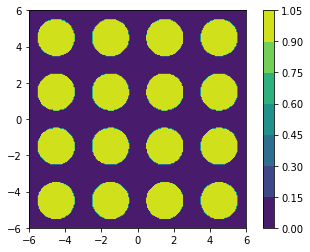

In [7]:
fig,ax = plt.subplots()
cbar = ax.contourf(xarr/a,xarr/a,mask_a)
ax.set_aspect('equal')
fig.colorbar(cbar)

## Analytically derived fields 

### Field in Fourier plane (A1)

In [124]:
## physics and system params
k = 2*pi/1.064e-6
A0 = 1
# want M = f2/f1 something like ~ .03
f1 = 1
f2 = 0.03
a = 1e-4 # aperture 1 radius = 100 um
b = f1*3.8317/(a*k) # the filter radius. 3.8317 is a00, the first zero of the J0(x).

dx = 3*a # center-to-center spacing between spots
dy = dx

In [174]:
w = 200*a
pts = 200
xarr,midpt,rr,phi = get_meshgrid(w, pts, polar=True)

field1 = zeros((pts,pts), complex)

dx = dy = 3*a
xnum = ynum = 4
xcents, ycents = get_grid(dx,dy,xnum,ynum)

def repeat_phase(i,j):
    # this works for a square grid; need a dedicated yarr otherwise
    x1 = xarr[i] 
    y1 = xarr[j]
    return (sin(xnum*k*dx*x1/(2*f1))*sin(ynum*k*dy*y1/(2*f1)) \
            /(sin(sin(k*dx*x1/(2*f1))*sin(k*dy*y1/(2*f1)))))

t0 = time()
q3_phases = empty((midpt, midpt), complex)
q3 = copy(field1[:midpt,:midpt])
for i in range(midpt):
    for j in range(midpt):
        q3_phases[i,j] = repeat_phase(i,j)
        q3[i,j] = A0*a*j1(a*rr[i,j]*k/f1)*q3_phases[i,j]/rr[i,j]
        
field1 = from_quadrant3(q3, field=field1)
print(f"calculated field1 in {time()-t0} s")

calculated field1 in 0.18949198722839355 s


Text(0.5, 1.0, 'Fourier Plane Periodic Factor (4x4 input)')

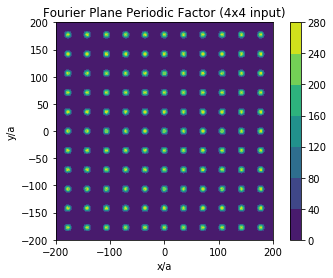

In [175]:
phases = from_quadrant3(q3_phases)
fig,ax = figax()
cbar = ax.contourf(xarr/a, xarr/a, phases**2)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(cbar)
ax.set_title(f'Fourier Plane Periodic Factor ({xnum}x{ynum} input)')
# plt.savefig(f'fourier_plane_{xnum}by{ynum}_periodic_factor.png',bbox_inches='tight')

In [35]:
b/a

64.88633711537092

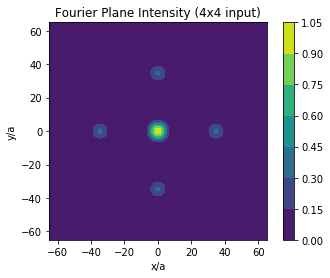

In [190]:
fig,ax = figax()
I1 = conjugate(field1)*field1
I1 /= amax(I1)
cbar = ax.contourf(xarr/a, xarr/a, I1)
roi = 65 # b/a
ax.set_xlim(-roi,roi)
ax.set_ylim(-roi,roi)

ax.set_title(f'Fourier Plane Intensity ({xnum}x{ynum} input)')
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(cbar)
# plt.savefig(f'fourier_plane_intensity_{xnum}by{ynum}',bbox_inches='tight')

In [188]:
amax(field1)

(0.45358938971291246+0j)

Text(0.5, 1.0, 'Fourier Plane Intensity | Focal Plane y=0 Slice')

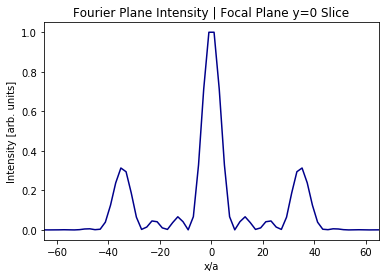

In [192]:
fig,ax = plt.subplots()
I1x = I1[midpt,:]
ax.plot(xarr/a, I1x, color='darkblue')
ax.set_xlim(-roi, roi)
# ax.set_ylim(0, .25)
ax.set_xlabel('x/a')
ax.set_ylabel('Intensity [arb. units]')
ax.set_title('Fourier Plane Intensity | Focal Plane y=0 Slice')
# plt.savefig(f'fourier_plane_intensity_{xnum}by{ynum}_y0slice',bbox_inches='tight')

### Field in output plane (A2)
As I derived based on Mark's notes. This is for a bright trap.

\begin{equation*} 
A_2(\mathbf{\rho_2}, z_2) = - \frac{k^2 A_0 a}{2 \pi f_1 f_2} \int_{-b}^b dx \int_{-\sqrt{b^2-x_1^2}}^{\sqrt{b^2-x_1^2}} dy \frac{\sin{(\frac{N k x_1 d}{2 f_1})}}{\sin{(\frac{k x_1 d}{2 f_1}})} \frac{\sin{(\frac{N k y_1 d}{2 f_1})}}{\sin{(\frac{k y_1 d}{2 f_1}})} \frac{J_1(a \rho_1 \frac{k}{f_1})}{\rho_1}\exp{\bigg(-\frac{i k}{2 f_2}(\rho_1^2(\frac{z_2}{f_2} - 1) + 2 \mathbf{\rho_1} \cdot \mathbf{\rho_2)}\bigg)}, \quad \rho_1 = \sqrt{x_1^2 + y_1^2}
\end{equation*}

Break up into real, imaginary to solve with scipy dblquad:

\begin{equation*} 
A_2(\mathbf{\rho_2}, z_2) = - \frac{k^2 A_0 a}{2 \pi f_1 f_2} \int_{-b}^b dx \int_{-\sqrt{b^2-x_1^2}}^{\sqrt{b^2-x_1^2}} dy \frac{\sin{(\frac{N k x_1 d}{2 f_1})}}{\sin{(\frac{k x_1 d}{2 f_1}})} \frac{\sin{(\frac{N k y_1 d}{2 f_1})}}{\sin{(\frac{k y_1 d}{2 f_1}})} \frac{J_1(a \rho_1 \frac{k}{f_1})}{\rho_1}\bigg(\cos{\bigg(\frac{k}{2 f_2}(\rho_1^2(\frac{z_2}{f_2} - 1) + 2 \mathbf{\rho_1} \cdot \mathbf{\rho_2)}\bigg)} \\ - i \sin{\bigg(\frac{k}{2 f_2}(\rho_1^2(\frac{z_2}{f_2} - 1) + 2 \mathbf{\rho_1} \cdot \mathbf{\rho_2)}\bigg)} \bigg), \quad \rho_1 = \sqrt{x_1^2 + y_1^2}
\end{equation*}

In [88]:
## physics and system params
lmbda = 1.064e-6
k = 2*pi/lmbda
A0 = 1
# want M = f2/f1 something like ~ .03
f1 = 1
f2 = 0.03
a = 1e-4 # aperture 1 radius = 100 um
b = f1*3.8317/(a*k) # the filter radius. 3.8317 is a00, the first zero of the J0(x).

dx = 3*a # center-to-center spacing between spots
dy = dx

In [159]:
# input field has 8x8 grid, d = 3a, so input field ~ 50a. f2/f1 ~ .02, so guess grid width ~ a
xnum = ynum = 4
z2 = f2 # the distance from lens f2

In [160]:
def re_iint(y1, x1, y2, x2, z2):
    """
    the real part of the integrand in the cell above for the output field.
    """
    
    r1 = sqrt(x1**2 + y1**2)
    
    intgd = (sin(xnum*k*dx*x1/(2*f1))*sin(ynum*k*dy*y1/(2*f1)) \
            /(sin(sin(k*dx*x1/(2*f1))*sin(k*dy*y1/(2*f1))))) \
            *j1(a*r1*k/f1)*cos(k*((z2/f2 - 1)*r1**2 + 2*(x1*x2 + y1*y2))/(2*f2))/r1
    
    return intgd


def im_iint(y1, x1, y2, x2, z2):
    """
    the imaginary part of the integrand in the cell above for the output field
    """
    
    r1 = sqrt(x1**2 + y1**2)
    
    intgd = - (sin(xnum*k*dx*x1/(2*f1))*sin(ynum*k*dy*y1/(2*f1)) \
              /(sin(sin(k*dx*x1/(2*f1))*sin(k*dy*y1/(2*f1))))) \
              *j1(a*r1*k/f1)*sin(k*((z2/f2 - 1)*r1**2 + 2*(x1*x2 + y1*y2))/(2*f2))/r1
    
    return intgd

    
def field2_int(x2, y2, z2):
    """ 
    compute the integral in the cell above for the output field 
    integral broken up to avoid the pole at x1=y1 = 0; only integrate over 
    quadrant one in the Fourier plane, then multiply the result by 4 to 
    account for the other quadrants. works by symmetry. 

    Args:
        x2
        y2
        z2: the distance from the second lens
    Return:
        'field': complex
    """
    
    # unconstrained limits: x in [-b,b], y in [-sqrt(b**2 - x**2), sqrt(b**2 - x**2)]
    # 1 quadrant: x in [0,b], y in [0, sqrt(b**2 - x**2)]. make lower bound finite in either x or y
    
    iargs = (y2, x2, z2)
    
    # avoid the pole in y
#     field2 = 4*(A0*a*k**2)*(dblquad(re_iint, 0, b, 
#                                   lambda x: 1e-6, # keep small enough to obtain good resolution
#                                   lambda x: sqrt(b**2 - x**2), 
#                                   args=iargs)[0]/(2*pi*f1*f2) 
#                           -1j*dblquad(im_iint, 0, b, 
#                                   lambda x: 1e-6, # keep small enough to obtain good resolution 
#                                   lambda x: sqrt(b**2 - x**2), 
#                                   args=iargs)[0]/(2*pi*f1*f2)) 

    # avoid the pole in x
    field2 = 4*(A0*a*k**2)*(dblquad(re_iint, 1e-6, b, 
                                  lambda x: 0, # keep small enough to obtain good resolution
                                  lambda x: sqrt(b**2 - x**2), 
                                  args=iargs)[0]/(2*pi*f1*f2) 
                          -1j*dblquad(im_iint, 1e-6, b, 
                                  lambda x: 0, # keep small enough to obtain good resolution 
                                  lambda x: sqrt(b**2 - x**2), 
                                  args=iargs)[0]/(2*pi*f1*f2)) 

    
    return field2

In [211]:
# build the meshgrid
w = a*0.12 # 2 x 2 grid, dx = dy = 3*a, M = .03, gridwidth out ~ ((xnum-1)*d + a)*.03 = .12*a
pts = 50

# only works for square grid; need to update. get xarr, yarr, midx, midy
xarr2,midpt,xx2,yy2 = get_meshgrid(w, pts, polar=False)

field2 = zeros((pts,pts), complex)

In [212]:
w*1e6

12.0

In [213]:
## compute quadrant 3 of the field -- Monte Carlo

t0 = time()
q3 = copy(field2[:midpt,:midpt])
for i in range(midpt):
    for j in range(midpt):
        q3[i,j] = field2_int(xx2[0,j], yy2[i,0] ,z2)
field2 = from_quadrant3(q3, field=field2)
print(f"calculated field2 in {(time()-t0)/3600} hrs")

calculated field2 in 0.032521035141415064 hrs


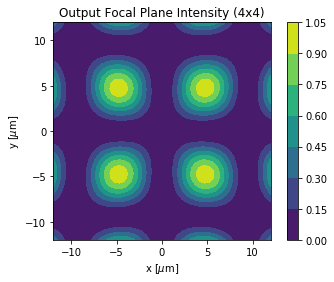

In [219]:
I2 = conjugate(field2)*field2
I2 /= amax(I2)

fig,ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
cbar = ax.contourf(xarr2/1e-6,xarr2/1e-6,I2)
fig.colorbar(cbar)
ax.set_title(f'Output Focal Plane Intensity ({xnum}x{ynum})')
# plt.savefig(f'f2_focalplane_intensity_{xnum}by{ynum}.png')

In [240]:
xarr2[int(midpt*1.4)]/1e-6

5.1428571428571415

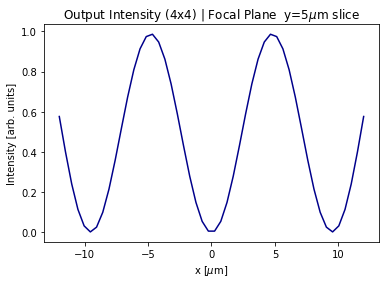

In [247]:
# fig,ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
fig,ax = plt.subplots()
I2x = I2[int(midpt*1.4),:] # get a slice through y = 5 um
ax.plot(xarr2/1e-6,I2x,color='darkblue')
ax.set_title(f'Output Intensity ({xnum}x{ynum}) | Focal Plane '+r' y=5$\mu$m slice')
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'Intensity [arb. units]')
# plt.savefig(f'f2_focalplane_intensity_{xnum}by{ynum}.png')

In [111]:
# monte-carlo sample the output field to check it
# ktests = int(pts) 
# irand = rand.sample(range(midpt), ktests)
# jrand = rand.sample(range(midpt), ktests)
# ktests**2

# integral speed test
# runs = 10
# times = []
# for i in range(runs):
#     t0 = time()
#     f = field2_int(xx2[0,j], yy2[i,0] ,z2)
#     t = time()-t0
#     times.append(t)
# #     print(f'calculated fieldxz2 in time {(t)} s')
# print(f'avg time = {sum(times)/runs} s')
# print(f'integral result = {f}')

## compute quadrant 3 of the field -- Monte Carlo

# t0 = time()
# q3 = copy(field2[:midpt,:midpt])
# for i in irand:
#     for j in jrand:
#         q3[i,j] = field2_int(xx2[0,j], yy2[i,0] ,z2)
# field2 = from_quadrant3(q3, field=field2)
# print(f"calculated field2 in {time()-t0} s")

10000

## Talbot Plane Analysis

In [230]:
## plot the field in the x2-z2 plane after lens 2. 
# could restrict to being on z-axis for a trap site

Lx2 = (f2*dx/f1) # output array periodicity
zTalbot = 2*Lx2**2/lmbda # Talbot length behind lens f2
numxpts = 50
numzpts = 500

w = a*0.12 # 2 x 2 grid, dx = dy = 3*a, M = .03, gridwidth out ~ ((xnum-1)*d + a)*.03 = .12*a
pts = 50

xpts2 = linspace(-w, w, numxpts)
zpts2 = linspace(f2 - 2*zTalbot, f2, numzpts) # plot two Talbot planes back from f2

In [229]:
zTalbot/w

12.687969924812029

In [251]:
for i,x in enumerate(xpts2):
    if x > 4.5e-6 and x < 5.5e-6:
        print(i,x)

34 4.653061224489797e-06
35 5.1428571428571415e-06


In [275]:
print(min(xx2[0]), max(xx2[0]))
print(min(xpts2), max(xpts2))
print(min(zpts2), max(zpts2))

-1.2e-05 1.2e-05
-1.2e-05 1.2e-05
0.02969548872180451 0.03


In [280]:
# plot just slice in x for y = 5um, z = f2. 
# This comes out correctly.
y2 = xpts2[35]
z2 = f2

xsoln = empty(numxpts, complex)
for i in range(midpt):
    xsoln[i] = field2_int(xpts2[i], y2 ,z2)

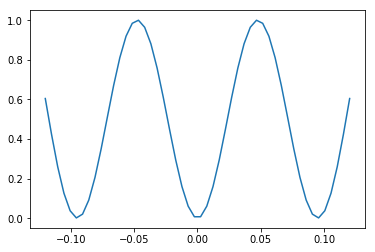

In [288]:
xsoln[midpt:] = flip(xsoln[:midpt])
ix2soln = conjugate(xsoln)*xsoln
ix2soln /= max(ix2soln)
plt.plot(xpts2/a, ix2soln)

In [294]:
midpt

25

In [297]:
## plot the field in the x2-z2 plane after lens 2. 

Lx2 = (f2*dx/f1) # output array periodicity
zTalbot = 2*Lx2**2/lmbda # Talbot length behind lens f2
numxpts = 50
numzpts = 500

w = a*0.12 # 2 x 2 grid, dx = dy = 3*a, M = .03, gridwidth out ~ ((xnum-1)*d + a)*.03 = .12*a
midx = int(numxpts/2)
xpts2 = linspace(-w, w, numxpts)
zpts2 = linspace(f2 - a, f2, numzpts) # plot two Talbot planes back from f2

In [289]:
zTalbot/a

1.5225563909774436

In [298]:
fieldxz2 = empty((numxpts,numzpts), complex)
y2 = xpts2[35] # the y plane to look at; about 5 um off axis

# compute above z axis, then reflect
assert numxpts % 2 == 0, "you're being stupid. you have to be able to reflect the field later"

t0 = time()
for i in range(midx): # only fill field midway through x. reflect about z axis later
    for j in range(pts):
        fieldxz2[i,j] = field2_int(xpts2[i], y2 ,zpts2[j])
print(f"calculated field2 in {(time()-t0)/60} mins")

calculated field2 in 8.12267476717631 mins


In [ ]:
# getting overflow values. TODO: get rid of pre-factors in the integral function. 

In [ ]:
fieldxz2[midx:,:] = flip(fieldxz2[:midx,:], axis=0)

In [303]:
Ixz2 = conjugate(fieldxz2)*fieldxz2
plt.contourf(Ixz2)

C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in multiply
  """Entry point for launching an IPython kernel.
C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [302]:
max(fieldxz2[:,35])

(26954600.988512482+36282380.25903089j)

C:\Users\gothr\Anaconda3\lib\site-packages\matplotlib\ticker.py:1967: RuntimeWarning: overflow encountered in double_scalars
  best_vmin = (_vmin // step) * step


ValueError: arange: cannot compute length

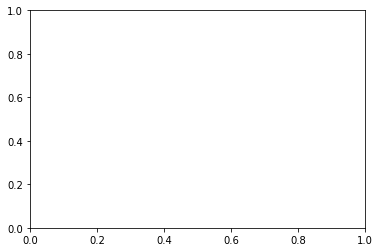

In [266]:
fieldxz2[midx:,:] = flip(fieldxz2[:midx,:],axis=0)

C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in multiply
  """Entry point for launching an IPython kernel.
C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


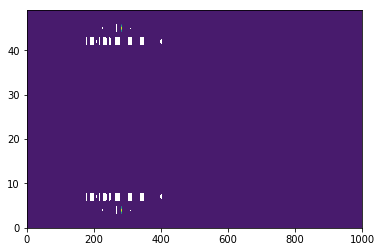

In [269]:
I2 = conjugate(fieldxz2)*fieldxz2
plt.contourf(I2)

In [72]:
full_fieldxz2.shape # i made an oopsie and didn't use even number of xpts

(25, 100)

Text(0.5, 1.0, 'XZ Slice of Field in Plane Behind Lens f2')

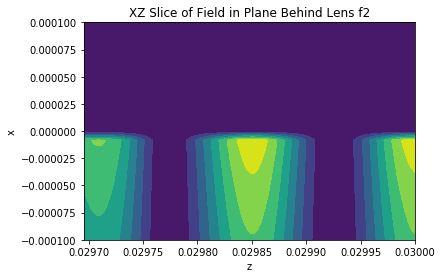

In [99]:
# reflect the field about the z axis:
# full_fieldxz2[midx:,:] = flip(fieldxz2[:midx,:])
fig,ax = figax(ylabel='x', xlabel='z')
ax.contourf(zpts2, xpts2[:midpt], conjugate(fieldxz2)*fieldxz2)
ax.set_title('XZ Slice of Field in Plane Behind Lens f2')

In [84]:
zTalbot

0.00015225563909774436